In [1122]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import PolynomialFeatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [1065]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Data pre-processing

By looking at our data we see there are some invalid values. To quantify them we look at the different features and compute the percentage of invalid values for each one of them.

In [1066]:
def print_percentages(array):
    for j in range(array.shape[1]):
        count_col = 0
        for i in range(array.shape[0]):
            if array[i,j] == -999:
                count_col += 1
        count_col = (count_col/array.shape[0])*100
        if (count_col > 0) : 
            print(f'For the feature {j+1} : {count_col} % of missing values')
        
print_percentages(tX)

For the feature 1 : 15.245600000000001 % of missing values
For the feature 5 : 70.9828 % of missing values
For the feature 6 : 70.9828 % of missing values
For the feature 7 : 70.9828 % of missing values
For the feature 13 : 70.9828 % of missing values
For the feature 24 : 39.9652 % of missing values
For the feature 25 : 39.9652 % of missing values
For the feature 26 : 39.9652 % of missing values
For the feature 27 : 70.9828 % of missing values
For the feature 28 : 70.9828 % of missing values
For the feature 29 : 70.9828 % of missing values


To process our data we choose to standardize it i.e. substracting the mean to each value of a feature to center the distribution of the feature at 0 and dividing it by the standard deviation of the feature distribution to obtain a distribution similar to a normal distribution for each feature. 

This allows us to give the mean of a feature as arbitrary value to otherwise undetermined values. This way we can still use features with invalid values for our methods if we wish to without them affecting our results too much. 

The standardization also allows us to avoid exponential computations with very large values, thus reducing the possibility of an overflow or other issues of this kind.

In [1067]:
# standardize the matrix 
def standardize(tX, normalized = False) :
    tX_standardized = tX.copy()
    for feature in tX_standardized.T : 
        mask = (feature != -999)
        i_mask = (feature == -999)
        feature[i_mask] = feature[mask].mean() # replace undetermined value by mean of other values in the feature column
        feature[:] = (feature-feature.mean())/feature.std() # standardize
        if normalized :
            feature[:] = (feature - np.amin(feature))/(np.amax(feature) - np.amin(feature)) # normalize
    tX_standardized.T[22] = tX.T[22] # Avoid standardization on categorical feature
    # tX_standardized = np.delete(tX_standardized, 7343, 0) #remove outlier
    tX_standardized = np.c_[tX_standardized, np.ones((tX.shape[0], 1))] # Add row of ones for better regression
    return tX_standardized

In [1068]:
# standardize the matrix (affected by undetermined values)
tX_standardized_af = standardize(tX)

### Features cleaning

Even after standardizing our data we might not want certain columns or rows. For this reason we create some masks to apply to our dataset that could improve accuracy

In [1114]:
mask_dict = {}
no_mask = np.full(tX_standardized_af.shape[1], True)
no_mask[30] = False
mask_dict["no_mask"] = no_mask

In [1115]:
# Create mask removing columns with unvalid data
remove_na_mask = []
for j in range(tX.shape[1]):
    remove_na_mask.append(not (-999 in tX[:,j]))
remove_na_mask.append(False) # for 1 column

mask_dict["remove_na_mask"] = remove_na_mask

In [1116]:
# Create mask removing columns with unvalid data except the first one because it has only 15% on error
remove_error_mask = []
for j in range(tX.shape[1]):
    remove_error_mask.append(not (-999 in tX[:,j]))
remove_error_mask[0] = True
remove_error_mask.append(False) # for 1 column

mask_dict["remove_error_mask"] = remove_error_mask

We notice some features do not have invalid data but do have a 0 value for almost every row containing some invalid data. We create a mask removing all of them in case it offers better accuracy on our methods.

In [1117]:
# Create mask removing all columns with unvalid or 0 data
remove_all_mask = []
for j in range(tX.shape[1]):
    remove_all_mask.append(not (-999 in tX[:,j]))
remove_all_mask[29] = False
remove_all_mask[22] = False
remove_all_mask.append(False)

mask_dict["remove_all_mask"] = remove_all_mask

We now want to create a mask selecting only the features bringing the most information about y. To do so we calculate the correlation of each of the features with y and select only the ones with best correlation.

In [1118]:
# Sort features based on their correlation with y
correlations = np.zeros(tX_standardized_af.shape[1] - 1)
for i in range(len(correlations)) :
    correlations[i] = np.corrcoef(y, tX_standardized_af.T[i])[0][1]
sorted_features_correlations = np.array(sorted(list(enumerate(correlations)), key=lambda x: -np.abs(x[1])))
sorted_features_indexes = np.array(sorted_features[:, 0], dtype = int)

In [1119]:
# Create a mask based on the n features with best correlation with y
n = 15
best_corr_mask = sorted(sorted_features_indexes[:n])


mask_dict["best_corr_mask"] = best_corr_mask 
best_corr_mask

[1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 21, 22, 23, 29]

In [1082]:
manual_mask = [1,2,3,4,5,6,7,8,9,10,11,22,23,24,25]
mask_dict["manual_mask"] = manual_mask

In [1076]:
# for i, feature in enumerate(tX_standardized.T) :
#    print("Feature " , i+1)
#    plt.plot(feature[:1000], y[:1000], 'kp', alpha = 0.006)
#    plt.show()

### Useful functions

In [1077]:
''' Calculate accuracy of model'''
def accuracy(weights, x, y):
    y_pred = predict_labels(weights, x)
    return np.count_nonzero(y == y_pred) / (y.shape[0])

In [1078]:
'''Create mask with feature with best accuracy
degree = 5
acc = []
for i in range(tX_standardized_af.shape[1] - 1) :
    tX_temp = tX_standardized_af[:, i]
    x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.8, seed = 2)
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    weights, loss = least_squares(y_train, x_train_poly)
    acc.append(accuracy(weights, x_test_poly, y_test))
sorted_accuracies = np.array(sorted(list(enumerate(acc)), key=lambda x: -np.abs(x[1])))
sorted_acc_indexes = np.array(sorted_accuracies[:, 0], dtype = int)'''

'Create mask with feature with best accuracy\ndegree = 5\nacc = []\nfor i in range(tX_standardized_af.shape[1] - 1) :\n    tX_temp = tX_standardized_af[:, i]\n    x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.8, seed = 2)\n    x_train_poly = build_poly(x_train, degree)\n    x_test_poly = build_poly(x_test, degree)\n    weights, loss = least_squares(y_train, x_train_poly)\n    acc.append(accuracy(weights, x_test_poly, y_test))\nsorted_accuracies = np.array(sorted(list(enumerate(acc)), key=lambda x: -np.abs(x[1])))\nsorted_acc_indexes = np.array(sorted_accuracies[:, 0], dtype = int)'

In [1045]:
'''n = 25
best_acc_mask = sorted(sorted_acc_indexes[:n])

mask_dict["best_acc_mask"] = best_acc_mask
best_acc_mask'''

'n = 25\nbest_acc_mask = sorted(sorted_acc_indexes[:n])\n\nmask_dict["best_acc_mask"] = best_acc_mask\nbest_acc_mask'

### Least squares

In [1079]:
for mask_key in mask_dict :    
    mask = mask_dict[mask_key]
    tX_temp = tX_standardized_af[:, mask]
    initial_w = np.zeros(tX_temp.shape[1])
    x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.8, seed = 1)

    weights, loss = least_squares(y_train, x_train)

    print(mask_key, ": Accuracy: ", accuracy(weights, x_test, y_test))

no_mask : Accuracy:  0.74414
remove_na_mask : Accuracy:  0.73396
remove_error_mask : Accuracy:  0.73448
remove_all_mask : Accuracy:  0.73254
best_corr_mask : Accuracy:  0.72196
manual_mask : Accuracy:  0.72768


### Least square with polynomial expansion on features

no_mask 

Max accuracy : 0.81548


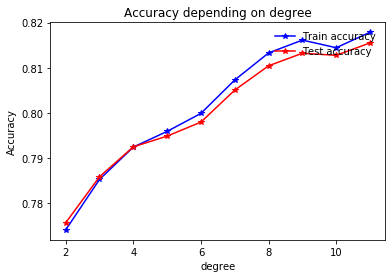

remove_na_mask 

Max accuracy : 0.79206


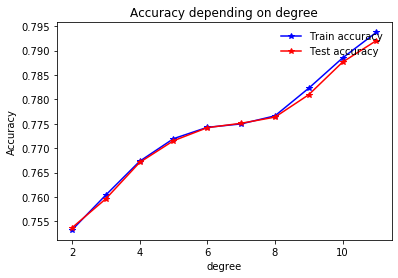

remove_error_mask 

Max accuracy : 0.8057


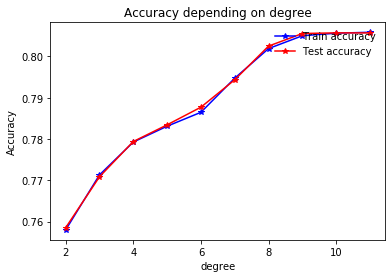

remove_all_mask 

Max accuracy : 0.79174


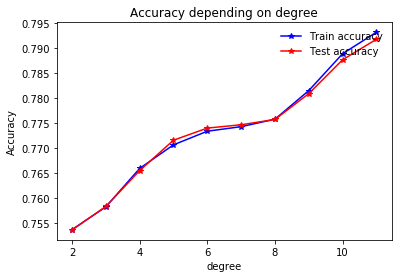

best_corr_mask 

Max accuracy : 0.76032


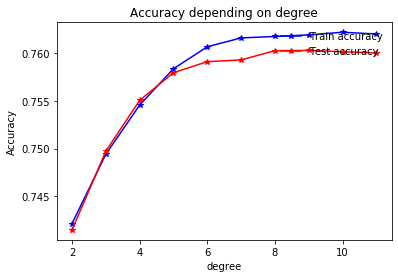

In [1125]:
for mask_key in mask_dict :
    mask = mask_dict[mask_key]
    tX_temp = tX_standardized_af[:, mask]
    initial_w = np.zeros(tX_temp.shape[1])
    x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.8, seed = 2)
    degrees = np.arange(2,12)
    acc_tr = []
    acc_te = []
    for ind, degree in enumerate(degrees):
        x_train_poly = build_multi_poly(x_train, degree)
        x_test_poly = build_multi_poly(x_test, degree)
        
        try:
            w, mse_loss_train = least_squares(y_train, x_train_poly)
        except np.linalg.LinAlgError:
            acc_tr.append(0.5)
            acc_te.append(0.5)
            continue
        acc_tr.append(accuracy(w, x_train_poly, y_train))
        acc_te.append(accuracy(w, x_test_poly, y_test))
    print(mask_key, '\n')
    print("Max accuracy :", np.amax(acc_te))
    plot_train_test(acc_tr, acc_te, degrees, "Accuracy depending on degree", p = "degree")

### Least square with the first 10 column and feature expansion

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


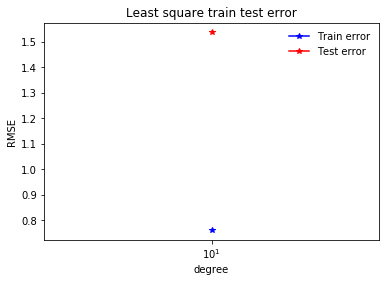

In [32]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degrees = [10]
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []

rmse_min = np.inf
degree_opt = 0
# disctionnary degree -> accuracy of the model on the test set given the degree
acc = {}
title = 'Least square train test error'
for ind, degree in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree)
    #train_poly_x = build_poly(x_train, degree)
    #test_poly_x = build_poly(x_test, degree)
    # polynomial expension
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)
    
    w, mse_loss_train = least_squares(y_train, train_poly_x)
    
    # keep track of the loss for ploting
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_test = compute_rmse(y_test, test_poly_x, w)
    rmse_te.append(rmse_test)
    acc[degree] = accuracy(w, test_poly_x, y_test)
    #if rmse_test < rmse_min:
    #    rmse_min = rmse_test
    #    weights = w
    #    degree_opt = degree
    weights = w
    
plot_train_test(rmse_tr, rmse_te, degrees, title)

In [31]:
acc

{10: 0.8036933333333334}

In [129]:
print(weights.shape)

(3003,)


In [991]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degrees = np.arange(1, 13)
# tuning which degree makes the best prediction on the validation set.
acc_tr = []
acc_te = []
acc_max = 0
title = 'Least square train test accuracy'

for ind, degree in enumerate(degrees):
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)
    
    w, mse_loss_train = least_squares(y_train, train_poly_x)
    
    acc_tr.append(accuracy(w, train_poly_x, y_train))
    acc_test = accuracy(w, test_poly_x, y_test)
    acc_te.append(acc_test)
    if acc_test > acc_max:
        weights = w
    
plot_train_test(acc_tr, acc_te, degrees, title)

LinAlgError: Singular matrix

In [25]:
acc_te

[0.7438,
 0.77104,
 0.7776666666666666,
 0.7840533333333334,
 0.7873866666666667,
 0.7904266666666667,
 0.7913333333333333,
 0.7927466666666667,
 0.7877866666666666,
 0.8036933333333334,
 0.8065466666666666,
 0.7658133333333333]

### Ridge regression with the first 10 columns and feature expension

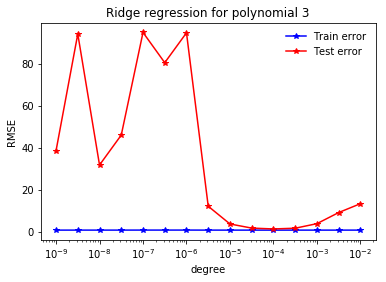

In [40]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 12
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = build_multi_poly(x_train, degree)
test_poly_x = build_multi_poly(x_test, degree)

for ind, lambda_ in enumerate(lambdas):
    
    w, loss = ridge_regression(y_train, train_poly_x, lambda_)
    
    # keep track of the loss for ploting
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_te.append(compute_rmse(y_test, test_poly_x, w))
    acc[lambda_] = accuracy(w, test_poly_x, y_test)
    if rmse_test < rmse_min:
        rmse_min = rmse_test
        weights = w
        lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

In [41]:
acc

{1.0000000000000001e-09: 0.8066533333333333,
 3.1622776601683795e-09: 0.8037066666666667,
 1e-08: 0.8061733333333333,
 3.1622776601683792e-08: 0.8033066666666666,
 9.9999999999999995e-08: 0.8008133333333334,
 3.1622776601683792e-07: 0.80128,
 9.9999999999999995e-07: 0.7949466666666667,
 3.1622776601683792e-06: 0.8064133333333333,
 1.0000000000000001e-05: 0.8067466666666666,
 3.1622776601683795e-05: 0.80688,
 0.0001: 0.8070266666666667,
 0.00031622776601683794: 0.8070266666666667,
 0.001: 0.8069466666666667,
 0.0031622776601683794: 0.8065066666666667,
 0.01: 0.80428}

accuracy test for degree 1 =  [0.7438, 0.7438, 0.7438, 0.7438, 0.7438, 0.7438, 0.7438, 0.7438, 0.7438266666666666, 0.7438133333333333, 0.7438533333333334, 0.7438133333333333, 0.7437866666666667, 0.7432133333333333, 0.7426933333333333]


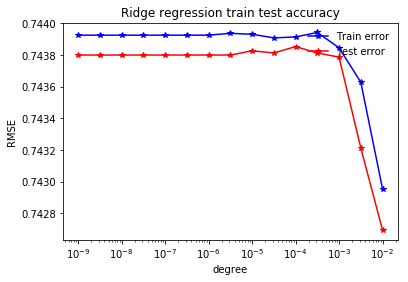

accuracy test for degree 2 =  [0.77104, 0.77104, 0.77104, 0.77104, 0.77104, 0.77104, 0.77104, 0.7710533333333334, 0.7710666666666667, 0.77108, 0.7711333333333333, 0.7709333333333334, 0.7708, 0.7706533333333333, 0.7698533333333333]


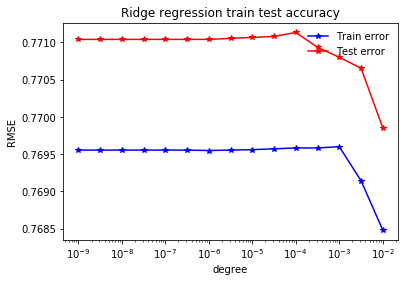

accuracy test for degree 3 =  [0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7776666666666666, 0.7777066666666667, 0.7776666666666666, 0.77768, 0.7775733333333333, 0.7774666666666666, 0.7771333333333333, 0.7759466666666667]


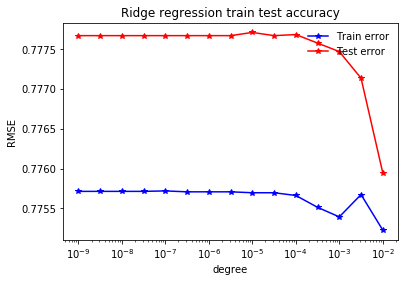

accuracy test for degree 4 =  [0.7840533333333334, 0.7840533333333334, 0.7840533333333334, 0.7840533333333334, 0.7840533333333334, 0.7840533333333334, 0.7840533333333334, 0.78404, 0.78404, 0.7841066666666666, 0.7841333333333333, 0.7840133333333333, 0.78392, 0.7838533333333333, 0.7830666666666667]


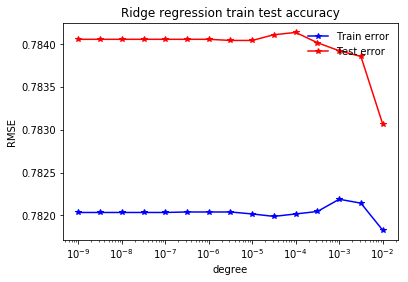

accuracy test for degree 5 =  [0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7873866666666667, 0.7874133333333333, 0.7874533333333333, 0.78732, 0.7873466666666666, 0.7876, 0.7875733333333333, 0.7872666666666667]


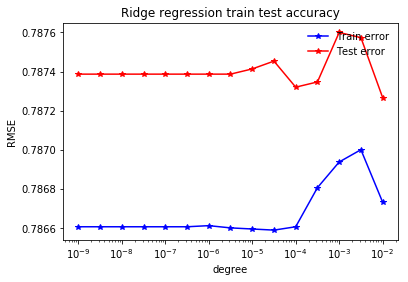

accuracy test for degree 6 =  [0.7904266666666667, 0.7904266666666667, 0.7904266666666667, 0.7904266666666667, 0.7904266666666667, 0.79044, 0.79044, 0.79048, 0.7904133333333333, 0.7904, 0.7903733333333334, 0.7903066666666667, 0.7906133333333333, 0.7903466666666666, 0.7896133333333333]


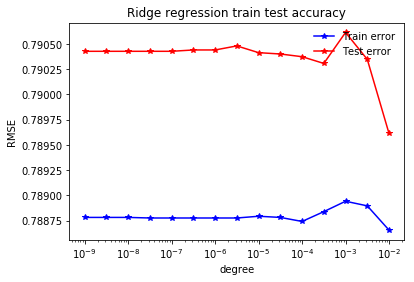

accuracy test for degree 7 =  [0.7913333333333333, 0.7913333333333333, 0.7913333333333333, 0.7913333333333333, 0.7913333333333333, 0.79132, 0.7913333333333333, 0.7913466666666666, 0.7914, 0.7914133333333333, 0.7915333333333333, 0.7914266666666666, 0.7914266666666666, 0.792, 0.7909466666666667]


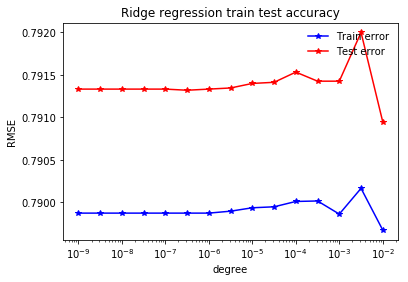

accuracy test for degree 8 =  [0.79276, 0.79276, 0.79276, 0.79276, 0.79276, 0.7927466666666667, 0.79276, 0.7927066666666667, 0.7926533333333333, 0.79252, 0.7927333333333333, 0.7927066666666667, 0.79272, 0.79292, 0.7922933333333333]


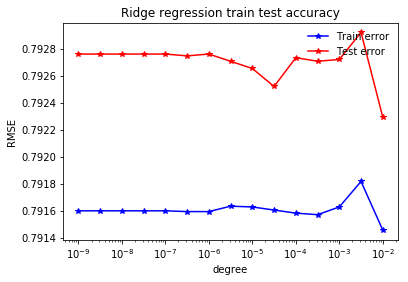

accuracy test for degree 9 =  [0.7879733333333333, 0.7879066666666666, 0.7879333333333334, 0.7878666666666667, 0.7878933333333333, 0.78776, 0.7877733333333333, 0.7878533333333333, 0.7884133333333333, 0.78952, 0.7897466666666667, 0.7922, 0.7942533333333334, 0.7976533333333333, 0.79656]


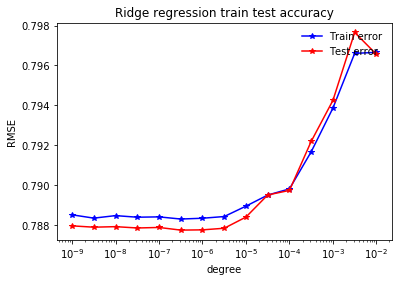

accuracy test for degree 10 =  [0.8034666666666667, 0.8034133333333333, 0.80344, 0.8034666666666667, 0.8034133333333333, 0.80344, 0.8034533333333334, 0.8032933333333333, 0.80328, 0.8032533333333334, 0.8032266666666666, 0.8033466666666667, 0.8033333333333333, 0.8033466666666667, 0.80152]


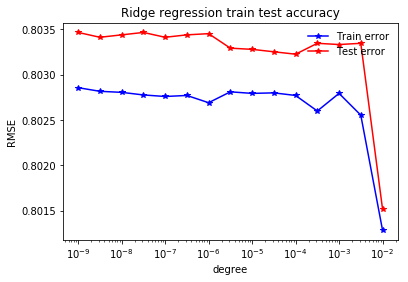

accuracy test for degree 11 =  [0.8058666666666666, 0.80584, 0.8058266666666667, 0.80588, 0.8058266666666667, 0.80584, 0.8058266666666667, 0.80576, 0.8060133333333334, 0.80612, 0.8061466666666667, 0.8062533333333334, 0.80616, 0.8060133333333334, 0.8044533333333334]


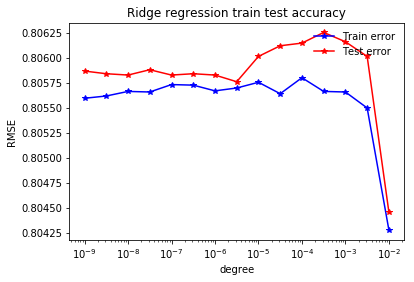

accuracy test for degree 12 =  [0.8066533333333333, 0.8037066666666667, 0.8061733333333333, 0.8033066666666666, 0.8008133333333334, 0.80128, 0.7949466666666667, 0.8064133333333333, 0.8067466666666666, 0.80688, 0.8070266666666667, 0.8070266666666667, 0.8069466666666667, 0.8065066666666667, 0.80428]


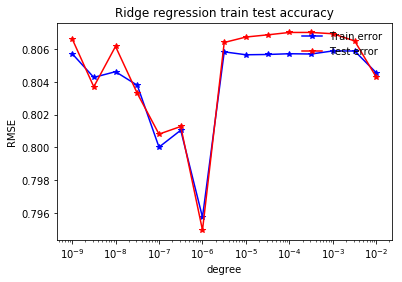

In [31]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degrees = np.arange(1, 13)


acc_max = 0
for ind_degree, degree in enumerate(degrees):
    acc_tr = []
    acc_te = []
    for ind, lambda_ in enumerate(lambdas):
        train_poly_x = build_multi_poly(x_train, degree)
        test_poly_x = build_multi_poly(x_test, degree)

        w, loss = ridge_regression(y_train, train_poly_x, lambda_)

        acc_tr.append(accuracy(w, train_poly_x, y_train))
        acc_test = accuracy(w, test_poly_x, y_test)
        acc_te.append(acc_test)
        if acc_test > acc_max:
            weights = w
    print('accuracy test for degree', degree, '= ', acc_te)
    title = 'Ridge regression train test accuracy'
    plot_train_test(acc_tr, acc_te, lambdas, title)

accuracy test for degree 12 =  [0.8168, 0.8167066666666667, 0.8168, 0.8166266666666666, 0.8170533333333333, 0.8164666666666667, 0.8152533333333334, 0.8154666666666667, 0.8155466666666666, 0.8149333333333333, 0.8142533333333334, 0.81424, 0.8143066666666666, 0.8152133333333333, 0.81392]


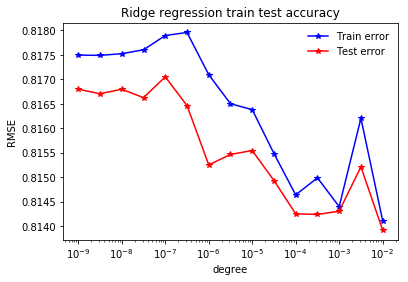

In [32]:
tX_temp = tX_standardized_af
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degree = 12

acc_max = 0

acc_tr = []
acc_te = []
for ind, lambda_ in enumerate(lambdas):
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)

    w, loss = ridge_regression(y_train, train_poly_x, lambda_)

    acc_tr.append(accuracy(w, train_poly_x, y_train))
    acc_test = accuracy(w, test_poly_x, y_test)
    acc_te.append(acc_test)
    if acc_test > acc_max:
        weights = w
print('accuracy test for degree', degree, '= ', acc_te)
title = 'Ridge regression train test accuracy'
plot_train_test(acc_tr, acc_te, lambdas, title)

accuracy test for degree 11 =  [0.81624, 0.81612, 0.8161066666666666, 0.81596, 0.8162266666666667, 0.8162266666666667, 0.8161866666666666, 0.8162133333333333, 0.81636, 0.8163333333333334, 0.8163333333333334, 0.81628, 0.8160266666666667, 0.8156, 0.8145333333333333]


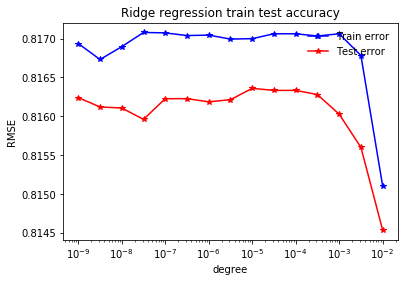

In [34]:
tX_temp = tX_standardized_af
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degree = 11

acc_max = 0

acc_tr = []
acc_te = []
for ind, lambda_ in enumerate(lambdas):
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)

    w, loss = ridge_regression(y_train, train_poly_x, lambda_)

    acc_tr.append(accuracy(w, train_poly_x, y_train))
    acc_test = accuracy(w, test_poly_x, y_test)
    acc_te.append(acc_test)
    if acc_test > acc_max:
        weights = w
print('accuracy test for degree', degree, '= ', acc_te)
title = 'Ridge regression train test accuracy'
plot_train_test(acc_tr, acc_te, lambdas, title)

### Logistic regression with the first 10 columns and extended features

In [ ]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 3
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)


train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)
weights, loss = logistic_regression(y, tX_temp, initial_w, 1000, 0.0000001)

# keep track of the loss for ploting
rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
rmse_te.append(compute_rmse(y_test, test_poly_x, w))
acc[lambda_] = accuracy(w, test_poly_x, y_test)
if rmse_test < rmse_min:
    rmse_min = rmse_test
    weights = w
    lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

### Logistic regression with columns removed

In [62]:
# polynomial expension
train_poly_x = build_multi_poly(tX_standardized_af[:, manual_mask], 7)
initial_w = np.zeros(train_poly_x.shape[1])
x_train, x_test, y_train, y_test = split_data(train_poly_x, y, 0.7, seed = 1)


weights, loss = logistic_regression(y_train, x_train, initial_w, 1000, 0.001)



/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:75: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(tx @ w)) - y * (tx @ w))
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:69: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-t)),
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:70: RuntimeWarning: overflow encountered in exp
  np.exp(t) / (1 + np.exp(t)))
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:70: RuntimeWarning: invalid value encountered in true_divide
  np.exp(t) / (1 + np.exp(t)))


In [63]:
y_pred = predict_labels(weights, x_test)
np.count_nonzero(y_test == y_pred) / (y_pred.shape[0])

0.5624533333333334

In [578]:
print(weights)

[ 2.58267765e-02 -6.85267338e-01 -1.01495128e+00  2.91998731e-01
 -3.11589633e-02  4.01266731e-01  4.16661756e-02  1.04064752e+00
 -9.14797437e-02  2.87061987e-01 -7.06948381e-01  2.50714125e-01
  2.19328298e-01  4.73925028e-01 -2.29059335e-03 -2.30463305e-03
  8.97754906e-01 -3.03452442e-03  6.84233625e-03  1.54091825e-01
  3.05476951e-04 -1.39990610e-01 -8.01590665e-02 -2.74284284e-01
  8.80844950e-04 -6.01861681e-04 -2.17767265e-01  5.67343756e-03
 -4.39140173e-03  2.84071572e-02 -8.05158341e-01]


In [567]:
w_0 = np.zeros(tX_temp.shape[1])
w_0[mask] = weights
weights = w_0

ValueError: NumPy boolean array indexing assignment cannot assign 31 input values to the 2 output values where the mask is true

## Generate predictions and save ouput in csv format for submission:

In [35]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [36]:
#standardize tX_test
tX_test_standardized = standardize(tX_test)
tX_test_standardized_af = standardize(tX_test, affected = True)

In [39]:
# extended feature here degree 4
tX_test = build_multi_poly(tX_test_standardized_af, 11)

In [40]:
OUTPUT_PATH = '../data/submission_file.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)